<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/notebooks/UniversalAttackGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Areas:
* Domain Generalization in Classification
* Domain Generalization in Mitosis Detection
* Universal Adversarial Example Generator
* An Aproach to Optimize Robustness and Performance Simultaneously
* Multi-Tasking using GradMaker
* Applications in Federated Learning


In [1]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import gc
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm.auto import tqdm

In [3]:
# config
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Param
num_epochs = 10
num_classes = 10
batch_size = 500
learning_rate = 0.001

In [4]:
# MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transforms.ToTensor(), download=True)

# MNIST dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# CNN(two layer)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
def validate(model, dloader, pert=None, is_batched=True):
    model.eval()
    correct = 0
    total = 0
    pert_ = pert(model, dloader) if (not is_batched) and (pert is not None) else None
    for i, (images, labels) in enumerate(tqdm(dloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        #
        if pert is not None:
            images = Variable(images.clone(), requires_grad=True)
            pert_ = pert(model, images, labels) if is_batched else pert_
            images = images.data.detach() + pert_.data.detach()
        #
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #
        # print(f"Batch {i}/{len(dloader)}, processed.")

        gc_collect(pert_, images, labels, outputs, predicted, _)
        empty_cache()
    return (100 * correct / total)

In [7]:
def gc_collect(*vars):
    for var in vars:
        del var
    gc.collect()

def empty_cache():
    torch.cuda.empty_cache()

In [8]:
model = ConvNet(num_classes).to(device)

# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
model.train()
total_step = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i + 1) % 100 == 0:
        #     print (f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Training Loss: {loss.item():.4f}')

# Test the model
print(f'Model Accuracy on the 10000 test images: {validate(model, test_loader):.4f} %')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Model Accuracy on the 10000 test images: 99.1300 %


### Now let's generate the attack


In [9]:
def adv_clip(adv, real, alpha=0):
    return torch.clamp(adv, min=torch.clamp(real-alpha, min=0.),
                       max=torch.clamp(real+alpha, max=1.))

In [10]:
def accuracy(model, X, y):
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct / total

In [23]:
def gradient_maker(grads, epochs = 100000, method="simple", start="zero", verbose=1, device=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device
    lr = 0.01
    n, d = grads.size()
    w = torch.randn(d) if start=="normal" else torch.zeros(d)
    w = w.to(device)
    for e in range(epochs):
        ge = grads[e%n]
        w_new = w + lr * (1. - (ge@w > 0).int()) * ge
        w = w_new if method=="simple" else w_new/torch.norm(w_new)
    pos_count = torch.sum(grads@w > 0)
    total_count = n
    if verbose > 0:
        print(f"For {epochs} epochs: {pos_count} out of {n}")
    return w, (pos_count, total_count)

In [12]:
def dX(model, X, y):
    X = Variable(X.data, requires_grad=True)
    outputs = model(X)
    loss = F.cross_entropy(outputs, y)
    loss.backward()
    return X.grad.data.clone()

## Testcases 
Let's first define some globals:

In [13]:
def imshow(X, index):
    plt.imshow(X[index,0].cpu().detach().numpy(), cmap='gray')
    plt.show()

In [14]:
eps = 0.1
steps = 20
alpha = eps/(0.75*steps)

In [15]:
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)

### Testcase 1
Let's see the effeciency of FGSM **attacks**

In [16]:
def fgsm(model, X, y, eps=0.1):
    advs = X + eps * torch.sign(dX(model, X, y))
    return adv_clip(advs, X, alpha=eps)

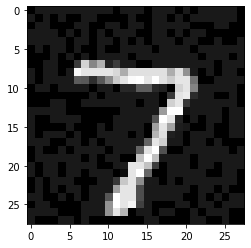

0.576


In [17]:
imshow(fgsm(model, X, y, eps), 0)
print(accuracy(model, fgsm(model, X, y, eps), y))

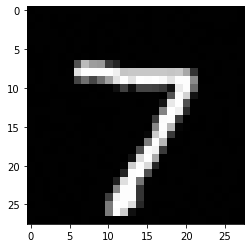

0.986


In [18]:
imshow(fgsm(model, X, y, alpha), 0)
print(accuracy(model, fgsm(model, X, y, alpha), y))

### Testcase 2

Let's see the efficiency of gradient maker in producing a simple one-step universal attack

In [22]:
X_grad = dX(model, X, y).detach().view(X.shape[0], -1)
g = gradient_maker(X_grad, device=device, epochs=100000)[0]

print(X_grad.shape, g.shape)
print("mins:", torch.min(X_grad), torch.min(X_grad@g), torch.min(g))
print("maxes:", torch.max(X_grad), torch.max(X_grad@g), torch.max(g))

# print(g)

For 100000 epochs: 401 out of 500
torch.Size([500, 784]) torch.Size([784])
mins: tensor(-0.0032, device='cuda:0') tensor(-4.3152e-11, device='cuda:0') tensor(-2.5265e-05, device='cuda:0')
maxes: tensor(0.0037, device='cuda:0') tensor(9.8447e-07, device='cuda:0') tensor(2.5464e-05, device='cuda:0')


In [24]:
def univ_1(model, X, y, eps=0.1):
    # X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
    X_grad = dX(model, X, y).detach().view(X.shape[0], -1)
    # onegrad = torch.from_numpy(gradient_maker(X_grad)).view(X.shape[1:]).to(device)
    onegrad = gradient_maker(X_grad, device=device)[0].view(X.shape[1:]).to(device)
    X_advs = adv_clip(X + eps * torch.sign(onegrad), X, eps)
    # return X_advs.type(torch.FloatTensor).to(device)
    return X_advs

For 100000 epochs: 401 out of 500


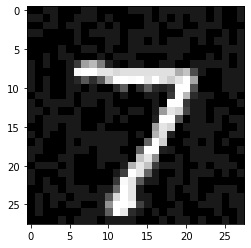

For 100000 epochs: 401 out of 500
0.98


In [25]:
imshow(univ_1(model, X, y, eps), 0)
print(accuracy(model, univ_1(model, X, y, eps), y))

For 100000 epochs: 401 out of 500


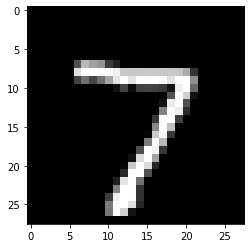

For 100000 epochs: 401 out of 500
0.994


In [26]:
imshow(univ_1(model, X, y, alpha), 0)
print(accuracy(model, univ_1(model, X, y, alpha), y))

Now, let's compare this with using simple fgsm as universal attack over the batch

In [27]:
accs = []
for i in tqdm(range(X.shape[0])):
    onegrad = torch.sign(dX(model, X, y))[i]
    X_ = adv_clip(X + eps * onegrad, X, eps)
    accs.append(accuracy(model, X_, y))
np.mean(accs)

  0%|          | 0/500 [00:00<?, ?it/s]

0.9834639999999999

### Testcase 3

In [28]:
def univ_2(model, X, y):
    print(steps, eps, alpha, steps*alpha)
    for step in tqdm(range(steps)):
        # X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
        X_grad = dX(model, X, y).detach().view(X.shape[0], -1)
        # onegrad = torch.from_numpy(gradient_maker(X_grad)).view(X.shape[1:]).to(device)
        onegrad = gradient_maker(X_grad, device=device)[0].view(X.shape[1:]).to(device)
        # X_advs = adv_clip(X + alpha * torch.sign(onegrad), X, eps).type(torch.FloatTensor).to(device)
        X_advs = adv_clip(X + alpha * torch.sign(onegrad), X, eps)
        X = Variable(X_advs.data, requires_grad=False)

        #
        gc_collect(X_advs, X_grad)
        empty_cache()
    return X

20 0.1 0.006666666666666667 0.13333333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

For 100000 epochs: 401 out of 500
For 100000 epochs: 408 out of 500
For 100000 epochs: 411 out of 500
For 100000 epochs: 408 out of 500
For 100000 epochs: 416 out of 500
For 100000 epochs: 413 out of 500
For 100000 epochs: 415 out of 500
For 100000 epochs: 415 out of 500
For 100000 epochs: 420 out of 500
For 100000 epochs: 422 out of 500
For 100000 epochs: 425 out of 500
For 100000 epochs: 429 out of 500
For 100000 epochs: 438 out of 500
For 100000 epochs: 433 out of 500
For 100000 epochs: 438 out of 500
For 100000 epochs: 436 out of 500
For 100000 epochs: 449 out of 500
For 100000 epochs: 449 out of 500
For 100000 epochs: 445 out of 500
For 100000 epochs: 451 out of 500


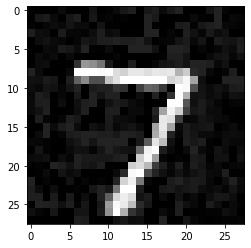

0.952


In [29]:
X_ = univ_2(model, X, y)
imshow(X_, 0)
print(accuracy(model, X_, y))

In [30]:
# # X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
# X_grad = dX(model, X, y).detach().view(X.shape[0], -1)
# print(X_grad.shape)

In [31]:
# X_grad = np.random.randn(200, 7840000)

In [32]:
# onegrad = gradient_maker(X_grad, device=device)[0]
# print(onegrad.shape)

In [33]:
# print(np.min(X_grad@onegrad), np.max(X_grad@onegrad))

In [34]:
# !pip install "dask[array]"

In [35]:
# import dask.array as da
# import gc

# def gc_collect(*vars):
#     for var in vars:
#         del var
#     gc.collect()

# def fake_gradient_maker(grads):
#     return grads[0]

# def log_essentials(grads):
#     #
#     eps = np.finfo(np.linalg.norm(grads).dtype).eps
#     TOLERANCE = max(eps * np.array(grads.shape))

#     #
#     # U, s, V = np.linalg.svd(grads)
#     _grads = da.from_array(grads.T)
#     _, _s, _ = da.linalg.svd(_grads)
#     s = _s.compute().T

#     #
#     gc_collect(_grads, _, _s)

#     #
#     x = np.linalg.lstsq(grads[:-1].T, grads[-1].T, None)

#     #
#     print(f"N={grads.shape[0]}, Tolerance={TOLERANCE}, SingularNorm={np.linalg.norm(s)/s.size}"
#           +f", Rank(Tol)={np.sum(s > TOLERANCE)}, Rank(1e-14)={np.sum(s > 1e-14)}"
#           +f", LinComb SSE={x[1]/grads.shape[0]}")

In [36]:
# log_essentials(X_grad)